In [1]:
import numpy as np
import math

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torch.multiprocessing as mp
from datetime import datetime

import pdb

from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# Utils
import data_generator
from variational_layer import VariationalLayer

In [2]:
is_cuda = False
dev = torch.device('cpu')  
if torch.cuda.is_available():
    is_cuda = True
    dev = torch.device('cuda')  

In [3]:
N = 5000
N_train = 3000
N_valid = N - N_train

In [4]:
X, y = data_generator.data_1to1(N)
X, y_perfect = data_generator.data_1to1(N, noise_level=0)

In [5]:
pca = PCA(n_components=1)
pca.fit(X)
X_plot = pca.transform(X)

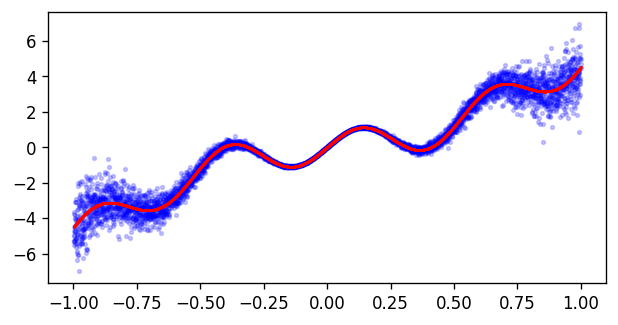

In [6]:
fig,ax = plt.subplots(figsize=(6,3), dpi=120)
plt.scatter(X_plot, y, c='blue', alpha=0.2, s=5)
plt.scatter(X_plot, y_perfect, c='r', alpha=0.7, s=0.3)

In [7]:
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

In [8]:
class ArtificialDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        return

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X_i = self.X[idx]
        y_i = self.y[idx]

        return X_i, y_i

In [9]:
dataset = ArtificialDataset(X, y)

data_train, data_valid = torch.utils.data.random_split(
    dataset, [N_train, N_valid])

BATCH_SIZE_LOADER = 64

training_loader = torch.utils.data.DataLoader(
    data_train, batch_size=BATCH_SIZE_LOADER,
    shuffle=True, num_workers=mp.cpu_count())

validation_loader = torch.utils.data.DataLoader(
    data_valid, batch_size=BATCH_SIZE_LOADER,
    shuffle=True, num_workers=mp.cpu_count())

In [10]:
class VariationalNet(nn.Module):
    # Initialize the layers
    def __init__(self, n_samples, input_size, output_size, K):
        super().__init__()
        self.n_samples = n_samples
        self.act1 = nn.ReLU()
        self.act2 = nn.Tanh()
        self.act3 = nn.Sigmoid()
        self.linear1 = VariationalLayer(input_size, 32, 0, 0.5, n_samples)
        #self.bn = nn.BatchNorm1d(16)
        self.linear2 = VariationalLayer(32, 16, 0, 0.5, n_samples)
        self.linear3 = VariationalLayer(16, output_size, 0, 0.5, n_samples)
        self.K = K
    
    # Perform the computation
    def forward(self, x):
        #pdb.set_trace()
        x = torch.unsqueeze(x, 0)
        x = x.expand((self.n_samples, x.shape[1], x.shape[2]))
        x = self.linear1(x)
        #x = self.bn(x)
        x = self.act1(x)
        x = self.linear2(x)
        x = self.act1(x)
        x = self.linear3(x)
        return x
    
    def kl_divergence_NN(self):
        kl = (
            self.linear1.kl_divergence_layer() 
            + self.linear2.kl_divergence_layer()
            + self.linear3.kl_divergence_layer()
        )
        return kl

In [18]:
n_samples = 10
input_size = X.shape[1]
output_size = 1

K = 1/500000

In [19]:
h = VariationalNet(n_samples, input_size, output_size, K).to(dev)
#h1 = ANN(input_size, output_size).to(dev)
#h2 = BayesianNetwork(1).to(dev)
opt_h = torch.optim.Adam(h.parameters(), lr=0.005)

mse_loss_mean = nn.MSELoss(reduction='mean')
mse_loss_sum = nn.MSELoss(reduction='sum')

In [20]:
BATCH_SIZE = 64

In [21]:
def train_one_epoch(epoch_index):
    
    mse_running_loss = 0.
    kl_running_loss = 0.
    
    n = len(training_loader.dataset)

    for i, data in enumerate(training_loader):
        
        x_batch, y_batch = data
        opt_h.zero_grad()

        y_preds = h(x_batch)
        y_preds_mean = y_preds.mean(axis=0).squeeze()

        mse_loss_ = mse_loss_sum(y_preds_mean, y_batch)
        kl_loss_ = h.K*h.kl_divergence_NN()
        
        elbo_loss = mse_loss_ + kl_loss_
        elbo_loss.backward()
        
        opt_h.step()
        
        mse_running_loss += mse_loss_.item()
        kl_running_loss += kl_loss_.item()
        
    mse = mse_running_loss/n
    kl = kl_running_loss/n

    return mse, kl

In [22]:
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
epoch_number = 0

EPOCHS = 150

for epoch in range(EPOCHS):
    print('------------------EPOCH {}------------------'.format(
        epoch_number + 1))

    h.train(True)
    avg_mse_loss, avg_kl_loss = train_one_epoch(
        epoch_number)
    avg_loss = avg_mse_loss + avg_kl_loss
    
    h.train(False)
    mse_running_loss_v = 0.0
    kl_running_loss_v = 0.0
    
    n = len(validation_loader.dataset)
    
    for i, vdata in enumerate(validation_loader):
        
        x_val_batch, y_val_batch = vdata

        y_val_preds = h(x_val_batch)
        y_val_preds_mean = y_val_preds.mean(axis=0).squeeze()
        
        mse_loss_ = mse_loss_sum(y_val_preds_mean, y_val_batch)
        kl_loss_ = h.K*h.kl_divergence_NN()
        elbo_loss = mse_loss_ + kl_loss_
        
        mse_running_loss_v += mse_loss_
        kl_running_loss_v += kl_loss_
        
    avg_vmseloss = (mse_running_loss_v / n).item()
    avg_vklloss = (kl_running_loss_v / n).item()
    
    avg_vloss = avg_vmseloss + avg_vklloss
    
    print('MSE LOSS \t train {} valid {}'.format(
        round(avg_mse_loss, 2), round(avg_vmseloss, 2)))
    print('KL LOSS \t train {} valid {}'.format(
        round(avg_kl_loss, 2), round(avg_vklloss, 2)))
    print('ELBO LOSS \t train {} valid {}'.format(
        round(avg_loss, 2), round(avg_vloss, 2)))

    epoch_number += 1

------------------EPOCH 1------------------
MSE LOSS 	 train 2.69 valid 0.91
KL LOSS 	 train 0.0 valid 0.0
ELBO LOSS 	 train 2.69 valid 0.91
------------------EPOCH 2------------------
MSE LOSS 	 train 0.74 valid 0.65
KL LOSS 	 train 0.0 valid 0.0
ELBO LOSS 	 train 0.74 valid 0.65
------------------EPOCH 3------------------
MSE LOSS 	 train 0.62 valid 0.6
KL LOSS 	 train 0.0 valid 0.0
ELBO LOSS 	 train 0.62 valid 0.6
------------------EPOCH 4------------------
MSE LOSS 	 train 0.58 valid 0.57
KL LOSS 	 train 0.0 valid 0.0
ELBO LOSS 	 train 0.58 valid 0.57
------------------EPOCH 5------------------
MSE LOSS 	 train 0.56 valid 0.55
KL LOSS 	 train 0.0 valid 0.0
ELBO LOSS 	 train 0.56 valid 0.55
------------------EPOCH 6------------------
MSE LOSS 	 train 0.54 valid 0.54
KL LOSS 	 train 0.0 valid 0.0
ELBO LOSS 	 train 0.54 valid 0.54
------------------EPOCH 7------------------
MSE LOSS 	 train 0.53 valid 0.53
KL LOSS 	 train 0.0 valid 0.0
ELBO LOSS 	 train 0.53 valid 0.53
---------------

MSE LOSS 	 train 0.25 valid 0.23
KL LOSS 	 train 0.0 valid 0.0
ELBO LOSS 	 train 0.25 valid 0.23
------------------EPOCH 60------------------
MSE LOSS 	 train 0.24 valid 0.24
KL LOSS 	 train 0.0 valid 0.0
ELBO LOSS 	 train 0.24 valid 0.24
------------------EPOCH 61------------------
MSE LOSS 	 train 0.24 valid 0.23
KL LOSS 	 train 0.0 valid 0.0
ELBO LOSS 	 train 0.24 valid 0.23
------------------EPOCH 62------------------
MSE LOSS 	 train 0.25 valid 0.24
KL LOSS 	 train 0.0 valid 0.0
ELBO LOSS 	 train 0.25 valid 0.24
------------------EPOCH 63------------------
MSE LOSS 	 train 0.25 valid 0.23
KL LOSS 	 train 0.0 valid 0.0
ELBO LOSS 	 train 0.25 valid 0.23
------------------EPOCH 64------------------
MSE LOSS 	 train 0.25 valid 0.23
KL LOSS 	 train 0.0 valid 0.0
ELBO LOSS 	 train 0.25 valid 0.23
------------------EPOCH 65------------------
MSE LOSS 	 train 0.25 valid 0.24
KL LOSS 	 train 0.0 valid 0.0
ELBO LOSS 	 train 0.25 valid 0.24
------------------EPOCH 66------------------
MSE LO

MSE LOSS 	 train 0.24 valid 0.24
KL LOSS 	 train 0.0 valid 0.0
ELBO LOSS 	 train 0.24 valid 0.24
------------------EPOCH 118------------------
MSE LOSS 	 train 0.24 valid 0.26
KL LOSS 	 train 0.0 valid 0.0
ELBO LOSS 	 train 0.24 valid 0.26
------------------EPOCH 119------------------
MSE LOSS 	 train 0.24 valid 0.23
KL LOSS 	 train 0.0 valid 0.0
ELBO LOSS 	 train 0.24 valid 0.23
------------------EPOCH 120------------------
MSE LOSS 	 train 0.24 valid 0.23
KL LOSS 	 train 0.0 valid 0.0
ELBO LOSS 	 train 0.24 valid 0.23
------------------EPOCH 121------------------
MSE LOSS 	 train 0.24 valid 0.23
KL LOSS 	 train 0.0 valid 0.0
ELBO LOSS 	 train 0.24 valid 0.23
------------------EPOCH 122------------------
MSE LOSS 	 train 0.24 valid 0.23
KL LOSS 	 train 0.0 valid 0.0
ELBO LOSS 	 train 0.24 valid 0.23
------------------EPOCH 123------------------
MSE LOSS 	 train 0.25 valid 0.24
KL LOSS 	 train 0.0 valid 0.0
ELBO LOSS 	 train 0.25 valid 0.24
------------------EPOCH 124------------------

In [23]:
def plot_test_curve(X_test, y_test, h):
    xt = torch.hstack(
    (X_test[:,0], 
     torch.tensor(np.arange(-1.4, -1, 1/500), dtype = torch.float32), 
     torch.tensor(np.arange(1, 1.4, 1/500), dtype = torch.float32)))
    
    plt.scatter(X_test[:,0].detach(), y_test.detach())
    for i in range(0, 100):
        plt.scatter(xt.detach(), 
                    h(xt.unsqueeze(1)).detach().squeeze()[0], 
                    color='r', alpha=0.01)
        plt.ylim([-10, 10])

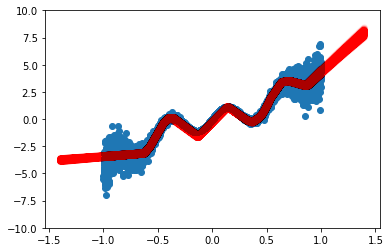

In [24]:
plot_test_curve(validation_loader.dataset.dataset.X,
               validation_loader.dataset.dataset.y,
               h)